# Todolist
- Gunakan Model yang Lebih Maju
- Membersihkan teks dari tanda baca yang tidak perlu atau melakukan tokenisasi yang lebih tepat
- Penyaringan atau pemrosesan lanjutan untuk memastikan bahwa jawaban yang dihasilkan relevan dan bermakna
- Perluas dataset pelatihan dengan pertanyaan yang lebih bervariasi dan relevan sehingga model memiliki lebih banyak informasi untuk merespons pertanyaan yang mungkin tidak ada dalam dataset

## Install package

In [1]:
# %pip install tensorflow pandas transformers datasets

## Import package

In [61]:
import pandas as pd
from datasets import Dataset
from transformers import TFBertForQuestionAnswering, BertTokenizerFast, DefaultDataCollator, create_optimizer
from transformers import TrainingArguments, Trainer
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

In [62]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress most TensorFlow messages
tf.get_logger().setLevel('ERROR')

In [63]:
# Ensure tf_keras is installed
try:
    import tf_keras
except ImportError:
    print("tf-keras is not installed. Installing now...")
    %pip install tf-keras

In [64]:
# Load the dataset
df = pd.read_csv('../data/final_dataset.csv')
dataset = Dataset.from_pandas(df)
print(df.head())

   id                                            context  \
0   1  ROI atau Return on Investment adalah rasio keu...   
1   2  EBITDA atau Earnings Before Interest, Taxes, D...   
2   3  Leverage dalam konteks finansial adalah penggu...   
3   4  Diversifikasi adalah strategi investasi yang m...   
4   5  Volatilitas adalah ukuran seberapa besar harga...   

                 question                                             answer  \
0            Apa itu ROI?  ROI atau Return on Investment adalah rasio keu...   
1         Apa itu EBITDA?  EBITDA atau Earnings Before Interest, Taxes, D...   
2       Apa itu Leverage?  Leverage dalam konteks finansial adalah penggu...   
3  Apa itu Diversifikasi?  Diversifikasi adalah strategi investasi yang m...   
4    Apa itu Volatilitas?  Volatilitas adalah ukuran seberapa besar harga...   

   answer_start  
0             0  
1             0  
2             0  
3             0  
4             0  


In [65]:
print(df.columns)

Index(['id', 'context', 'question', 'answer', 'answer_start'], dtype='object')


In [66]:
# Load the tokenizer and model for fine-tuning
model_name = "Rifky/Indobert-QA"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = TFBertForQuestionAnswering.from_pretrained(model_name)

c:\Users\alifs\anaconda3\envs\main-ds\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForQuestionAnswering were initialized from the PyTorch 

In [67]:
# Load pre-trained model for generating answers when context is not found
pretrained_model = TFBertForQuestionAnswering.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


# Tokenize dataset

In [68]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )
    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answer"]
    start_positions = []
    end_positions = []

    for i, (answer, offset) in enumerate(zip(answers, offset_mapping)):
        start_char = examples["answer_start"][i]
        end_char = start_char + len(answer)

        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            start_idx = context_start
            while start_idx <= context_end and offset[start_idx][0] <= start_char:
                start_idx += 1
            start_positions.append(start_idx - 1)

            end_idx = context_start
            while end_idx <= context_end and offset[end_idx][1] < end_char:
                end_idx += 1
            end_positions.append(end_idx - 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs


In [69]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/490 [00:00<?, ? examples/s]

In [70]:
# Split dataset into train and validation
train_test_split = tokenized_datasets.train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

In [71]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="../models/fine_tuned_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    # num_train_epochs=1,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='../logs',
    logging_steps=10,
    max_steps=1000,
)

In [72]:
# Create a data collator
data_collator = DefaultDataCollator(return_tensors="tf")

In [73]:
# Convert datasets to tf.data.Dataset
tf_train_dataset = train_dataset.shuffle(seed=42).to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    batch_size=4,
    collate_fn=data_collator,
    shuffle=True,
)
tf_eval_dataset = eval_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    batch_size=4,
    collate_fn=data_collator,
    shuffle=False,
)

In [74]:
# Create optimizer and compile model
num_train_steps = len(tf_train_dataset) * training_args.num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=training_args.learning_rate,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=training_args.weight_decay,
)

In [75]:
model.compile(optimizer=optimizer, metrics=['accuracy'])

In [76]:
class LossAccuracyLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LossAccuracyLogger, self).__init__()
        self.epoch_loss = []
        self.epoch_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_loss.append(logs['loss'])
        if 'accuracy' in logs:
            self.epoch_accuracy.append(logs['accuracy'])

    def plot(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.epoch_loss, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(self.epoch_accuracy, label='Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

In [77]:
logger = LossAccuracyLogger()

In [17]:
# Define metrics
# accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# f1_metric = tf.keras.metrics.F1Score(average='micro')

In [78]:
class MetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self, eval_dataset):
        super(MetricsLogger, self).__init__()
        self.epoch_accuracy = []
        self.epoch_f1 = []
        self.eval_dataset = eval_dataset

    def on_epoch_end(self, epoch, logs=None):
        if 'accuracy' in logs:
            self.epoch_accuracy.append(logs['accuracy'])
        else:
            self.epoch_accuracy.append(None)
        
        # Compute F1 score manually
        y_true_start, y_true_end = [], []
        y_pred_start, y_pred_end = [], []
        
        for batch in self.eval_dataset:
            inputs = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            labels = {k: v for k, v in batch.items() if k in ['start_positions', 'end_positions']}
            start_true = labels['start_positions'].numpy()
            end_true = labels['end_positions'].numpy()
            outputs = self.model.predict(inputs)
            start_pred = np.argmax(outputs['start_logits'], axis=-1)
            end_pred = np.argmax(outputs['end_logits'], axis=-1)
            
            y_true_start.extend(start_true)
            y_true_end.extend(end_true)
            y_pred_start.extend(start_pred)
            y_pred_end.extend(end_pred)
        
        start_f1 = f1_score(y_true_start, y_pred_start, average='micro')
        end_f1 = f1_score(y_true_end, y_pred_end, average='micro')
        overall_f1 = (start_f1 + end_f1) / 2
        self.epoch_f1.append(overall_f1)

    def plot(self):
        epochs = range(1, len(self.epoch_accuracy) + 1)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.epoch_accuracy, label='Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.epoch_f1, label='F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.show()

In [79]:
# Instantiate the callback
metrics_logger = MetricsLogger(tf_eval_dataset)

In [80]:
# Fine-tune the model
model.fit(tf_train_dataset, epochs=training_args.num_train_epochs, callbacks=[logger, metrics_logger], validation_data=tf_eval_dataset)

111/111 [==============================] - 548s 5s/step - loss: 1.0226 - end_logits_accuracy: 0.4943 - start_logits_accuracy: 0.8707 - val_loss: 0.7147 - val_end_logits_accuracy: 0.5918 - val_start_logits_accuracy: 0.8571


In [178]:
# Error analysis
# for example in train_dataset:
#     input_ids = tf.convert_to_tensor([example['input_ids']])
#     attention_mask = tf.convert_to_tensor([example['attention_mask']])
#     # Hapus pemanggilan model di sini
#     start_logits, end_logits = model(input_ids=input_ids, attention_mask=attention_mask, training=False)
#     start_index = tf.argmax(start_logits, axis=-1)[0].numpy()
#     end_index = tf.argmax(end_logits, axis=-1)[0].numpy()
#     predicted_answer = tokenizer.decode(input_ids[0][start_index:end_index + 1])
#     true_answer = example['answer']
#     # Hanya cetak hasil prediksi di sini
#     if predicted_answer != true_answer:
#         print("Question:", example['question'])
#         print("Predicted Answer:", predicted_answer)
#         print("True Answer:", true_answer)
#         print()

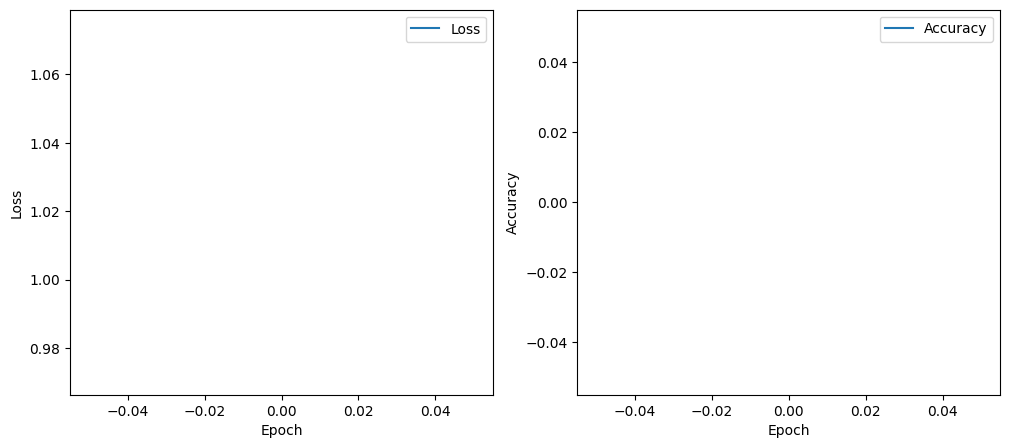

In [85]:
logger.plot()

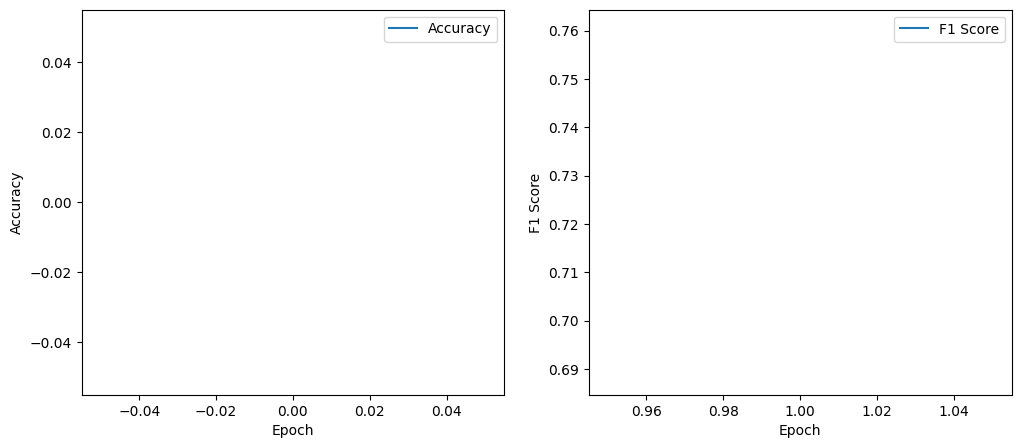

In [84]:
metrics_logger.plot()

In [86]:
# Function to answer a question using the fine-tuned model or the pretrained model
def answer_question(question, context, use_pretrained=False):
    if context is None:
        use_pretrained = True  # Use pretrained model if context is not available
    inputs = tokenizer(question, context, return_tensors="tf")
    if use_pretrained:
        outputs = pretrained_model(inputs)
    else:
        outputs = model(inputs)
    answer_start = tf.argmax(outputs.start_logits, axis=1).numpy()[0]
    answer_end = tf.argmax(outputs.end_logits, axis=1).numpy()[0] + 1
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))
    return answer

In [87]:
# Function to find context based on the question using Jaccard similarity
def find_context_for_question(question, dataframe):
    max_matched_words = 0
    best_matched_context = None
    context_found = False

    # Iterate through the rows of the dataframe
    for _, row in dataframe.iterrows():
        if question.strip().lower() in row['question'].strip().lower():
            best_matched_context = row['context']
            context_found = True
            break  # Break the loop if a matching context is found

    # If no exact match is found, find the best matching context based on the number of common words
    if not context_found:
        for _, row in dataframe.iterrows():
            dataset_tokens = set(row['question'].strip().lower().split())
            matched_words = len(set(question.strip().lower().split()).intersection(dataset_tokens))
            if matched_words > max_matched_words:
                max_matched_words = matched_words
                best_matched_context = row['context']

    return best_matched_context, context_found

In [88]:
# Function to provide a recommendation when no answer is found in the dataset
def provide_recommendation():
    return ("Terima kasih atas pertanyaannya! Meskipun tidak ada jawaban langsung dari kami, berikut adalah "
            "beberapa rekomendasi umum untuk membantu keuangan anda:\n\n"
            "1. Mulailah dengan membuat anggaran dan mengelola pengeluaran Anda dengan cermat.\n"
            "2. Pertimbangkan untuk mencari peluang sampingan atau pekerjaan paruh waktu.\n"
            "3. Pelajari dan investasikan uang Anda dengan bijak. Mungkin Anda ingin mempertimbangkan untuk berinvestasi dalam saham, obligasi, atau properti.\n"
            "4. Kembangkan keterampilan yang bernilai tinggi dan pertimbangkan untuk memonetisasi hobi atau minat Anda.\n"
            "5. Jangan lupa untuk memiliki perencanaan keuangan jangka panjang, termasuk perencanaan pensiun dan perlindungan asuransi.\n\n"
            "Semoga ini membantu Anda memulai perjalanan keuangan Anda!")

In [89]:
# Function to provide a recommendation when no answer is found in the dataset
def provide_recommendation_for_question(question):
    # Implement your recommendation logic here based on the question
    return provide_recommendation() 

In [114]:
# User input for the question
# user_question = input("Enter your financial question: ")
# user_question = "Apa itu EBITDA"
user_question = "Apa yang dimaksud dengan tabungan"

In [115]:
# Find context for the user's question
# context = find_context_for_question(user_question, df)
context, context_found = find_context_for_question(user_question, df)

In [116]:
# Function to find context based on the question
# Mendekati dataset
# Tidak disarankan karena halusinasi

def provide_recommendation_for_question(question):
    max_matched_words = 0
    best_matched_context = None

    # Iterate through the rows of the dataset
    for _, row in df.iterrows():
        dataset_tokens = set(row['question'].strip().lower().split())
        matched_words = len(set(question.strip().lower().split()).intersection(dataset_tokens))
        if matched_words > max_matched_words:
            max_matched_words = matched_words
            best_matched_context = row['context']

    if best_matched_context:
        return best_matched_context
    else:
        return provide_recommendation()

In [117]:
if context_found:
    # Get the answer to the user question using the found context
    answer = answer_question(user_question, context)
    print(f"Q: {user_question}\nA: {answer}")
else:
    # If context is not found, provide a recommendation based on the user's question
    answer = provide_recommendation_for_question(user_question)
    print(f"Q: {user_question}\nA: {answer}")

Q: Apa yang dimaksud dengan tabungan
A: tabungan adalah praktik menyimpan uang di suatu tempat yang aman, seperti bank, dengan tujuan untuk digunakan di masa mendatang


In [265]:
# Save the model at the end
# model.save_pretrained("../models/fine_tuned_model")
# tokenizer.save_pretrained("../models/fine_tuned_model")